# Segmentation

Extract neuronal locations and planar time-traces.

- Apply the constrained nonnegative matrix factorization (CNMF) source separation algorithm to extract initial estimates of neuronal spatial footprints and calcium traces.
- Apply quality control metrics to evaluate the initial estimates, and narrow down to the final set of estimates.

We will use the same strategy as for motion correction. That is, to evaluate parameter sets for a single z-plane before applying those parameters to subsequent z-planes.

In [85]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path
import logging

import mesmerize_core as mc
import warnings
from mesmerize_core.caiman_extensions.cnmf import cnmf_cache

from caiman.source_extraction.cnmf import cnmf, params
from caiman.motion_correction import high_pass_filter_space
from caiman.summary_images import correlation_pnr
from caiman.utils.visualization import nb_view_quilt
from lbm_caiman_python import get_metadata

import matplotlib.pyplot as plt
import fastplotlib as fpl
import pandas as pd
import numpy as np
import zarr
from ipywidgets import IntSlider, VBox
from sidecar import Sidecar

try:
    import cv2
    cv2.setNumThreads(0)
except():
    pass
warnings.filterwarnings('ignore')
if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

pd.options.display.max_colwidth = 120

# Unneeded in newer versions of mesmerize-core
os.environ['CONDA_PYTHON_EXE'] = "/home/flynn/miniforge3/bin/python"
os.environ['CONDA_PREFIX_1'] = "lcp"

logger = logging.getLogger("caiman")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
log_format = logging.Formatter("%(relativeCreated)12d [%(filename)s:%(funcName)10s():%(lineno)s] [%(process)d] %(message)s")
handler.setFormatter(log_format)
logger.addHandler(handler)

logging.getLogger("caiman").setLevel(logging.WARNING)

## Data path setup

Data setup is similar to [motion_correction notebook](./motion_correction.ipynb).

- you can use the **same batch path** and simply add onto the end of it.
- you can define a **completely new** batch path to store these items separately.

Here, to keep data organized, we will:
1. define our previous analaysis path as `mcorr_batch_path`
2. create a new 'cnmf.pickle` to save our cnmf results.

In [86]:
# Load MCORR batch and set raw data path
parent_path = Path().home() / "caiman_data"
data_path = parent_path / 'out'                # where the output files from the assembly step are located
mcorr_batch_path = data_path / 'batch.pickle'  # same as motion correction

mc.set_parent_raw_data_path(str(parent_path))

mcorr_df = mc.load_batch(mcorr_batch_path)
mcorr_df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,mcorr,plane_10.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4_mean_projection.n...,2024-12-06T12:49:01,2024-12-06T12:57:02,248.16 sec,None,d2323217-2056-4681-9656-2ddebc721ac4
1,mcorr,plane_1.tiff,plane_1.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': 61304ca6-5926-40ee-a769-77cc7baef155\61304ca6-5926-40ee-a769-77cc7baef155_mean_projection.n...,2024-12-06T14:59:55,2024-12-06T15:04:08,246.5 sec,None,61304ca6-5926-40ee-a769-77cc7baef155
2,mcorr,plane_11.tiff,plane_11.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': f8e52582-bdbc-40cd-aeee-b21742053d3e\f8e52582-bdbc-40cd-aeee-b21742053d3e_mean_projection.n...,2024-12-06T14:59:55,2024-12-06T15:08:19,250.41 sec,None,f8e52582-bdbc-40cd-aeee-b21742053d3e
3,mcorr,plane_12.tiff,plane_12.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': 4879bb5f-b35f-4f83-83f3-5fe74515bcae\4879bb5f-b35f-4f83-83f3-5fe74515bcae_mean_projection.n...,2024-12-06T14:59:55,2024-12-06T15:12:31,252.04 sec,None,4879bb5f-b35f-4f83-83f3-5fe74515bcae
4,mcorr,plane_13.tiff,plane_13.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': d7a820f6-3838-4faf-9e1d-25a5caa9345d\d7a820f6-3838-4faf-9e1d-25a5caa9345d_mean_projection.n...,2024-12-06T14:59:55,2024-12-06T15:16:44,252.66 sec,None,d7a820f6-3838-4faf-9e1d-25a5caa9345d
5,mcorr,plane_14.tiff,plane_14.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': 707fa711-d8e1-457f-be19-ae530dbf6320\707fa711-d8e1-457f-be19-ae530dbf6320_mean_projection.n...,2024-12-06T14:59:55,2024-12-06T15:20:57,253.18 sec,None,707fa711-d8e1-457f-be19-ae530dbf6320
6,mcorr,plane_15.tiff,plane_15.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': c32aa81d-e6d2-41a6-9206-eeed2dfd033a\c32aa81d-e6d2-41a6-9206-eeed2dfd033a_mean_projection.n...,2024-12-06T14:59:55,2024-12-06T15:25:09,250.99 sec,None,c32aa81d-e6d2-41a6-9206-eeed2dfd033a
7,mcorr,plane_16.tiff,plane_16.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': 676e935b-15e3-49ae-bbac-575e0e52dac6\676e935b-15e3-49ae-bbac-575e0e52dac6_mean_projection.n...,2024-12-06T14:59:55,2024-12-06T15:29:21,251.84 sec,None,676e935b-15e3-49ae-bbac-575e0e52dac6
8,mcorr,plane_17.tiff,plane_17.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': aef5cb01-b47a-4308-9110-0b16b16b8440\aef5cb01-b47a-4308-9110-0b16b16b8440_mean_projection.n...,2024-12-06T14:59:55,2024-12-06T15:33:30,248.93 sec,None,aef5cb01-b47a-4308-9110-0b16b16b8440
9,mcorr,plane_18.tiff,plane_18.tiff,"{'main': {'dxy': (1.04, 1.0), 'fr': 9.60806, 'max_shifts': (2, 2), 'strides': (12, 12), 'overlaps': (6, 6), 'max_dev...",{'mean-projection-path': 6b973436-e9db-40e5-be52-882fe29efc75\6b973436-e9db-40e5-be52-882fe29efc75_mean_projection.n...,2024-12-06T14:59:55,2024-12-06T15:37:39,248.9 sec,None,6b973436-e9db-40e5-be52-882fe29efc75


In [132]:
# Now create/load a new CNMF batch
cnmf_df_path = data_path / 'cnmf_batch.pickle'
if not cnmf_df_path.exists():
    print(f'creating batch: {cnmf_df_path}')
    cnmf_df = mc.create_batch(cnmf_df_path)
else:
    cnmf_df = mc.load_batch(cnmf_df_path)

In [133]:
cnmf_df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,cnmf,mcorr_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 50, 'gSig': (7, 7),...",{'mean-projection-path': a5c2f791-6d1b-4712-a66f-2c92adde5d61\a5c2f791-6d1b-4712-a66f-2c92adde5d61_mean_projection.n...,2024-12-07T14:25:59,2024-12-07T16:01:05,363.6 sec,None,a5c2f791-6d1b-4712-a66f-2c92adde5d61


- [get_input_movie_path()](https://mesmerize-core.readthedocs.io/en/latest/api/common.html#mesmerize_core.CaimanSeriesExtensions.get_input_movie_path) allows us to easily get filepaths to our raw files

In [89]:
# we get metadata from our raw files
tiff_files = [mcorr_df.iloc[i].caiman.get_input_movie_path() for i in mcorr_df.index]
metadata = get_metadata(tiff_files[0])

## CNMF Parameters

In this section, we'll define a `parameters` object that will subsequently be used to initialize our different estimators. 

| Parameter       | Description                                                                                                                                                                                                                                                                             | Default/Typical Value                        |
|------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------|
| `decay_time`    | Length of a typical transient in seconds. Approximation of the time scale for significant shifts in calcium signal. Defaults to `0.4` for fast indicators (e.g., GCaMP6f). Use `1` or more for slow indicators. Precise fitting is not necessary.                                       | 0.4 (fast indicators)                       |
| `p`             | Order of the autoregressive model. Use `p=0` to turn off deconvolution. Set `p=1` for instantaneous transients (e.g., low sample rate or slow indicator). Set `p=2` for visible rise time transients. Incorrect order leads to unreliable spike extraction.                              | 1 (slow), 2 (visible rise time)             |
| `nb`            | Number of global background components. Defaults to `2` for relatively homogeneous backgrounds. Use `3` for more complex noise, `1` is usually too low. Too low `nb` causes noisy traces; too high absorbs neuronal signals, reducing transients.                                       | 2                                           |
| `merge_thr`     | Merging threshold for components after initialization. Components correlated above this threshold are merged, useful for splitting neurons during initialization.                                                                                                                       | Typically between 0.7 and 0.9               |
| `rf`            | Half-size of patches in pixels. Should be at least 3–4 times larger than neuron size to capture the neuron and local background. Larger patches reduce parallelization.                                                                                                                | 3–4 × expected neuron size                  |
| `stride`        | Overlap between patches in pixels. Typically set to neuron diameter. Larger values increase computational load but improve reconstruction/denoising.                                                                                                                                | Neuron diameter (~10–20 pixels)             |
| `K`             | Expected number of components per patch. Adjust based on patch size (`rf`) and component density.                                                                                                                                                                                     | Varies based on data                        |
| `gSig`          | Expected half-size of neurons in pixels `[rows X columns]`. This is a **crucial** parameter for accurate component detection.                                                                                                                                                        | Typically matches neuron half-size          |
| `method_init`   | Initialization method. Depends on the recording method: use `greedy_roi` for 2p data, `corr_pnr` for 1p data, and `sparse_nmf` for dendritic/axonal data.                                                                                                                              | `greedy_roi`, `corr_pnr`, `sparse_nmf`      |
| `ssub/tsub`     | Spatial and temporal subsampling during initialization. Defaults to `1` (no compression). Increase (e.g., `2` or more) to save resources but at the potential cost of impaired detection/extraction quality.                                                                           | 1 (no compression), 2+ (for resource saving)|

### **The most important step**

We need to tell CaImAn our neuron size, and how many neurons to expect.

- `gSig`: Your neurons *half-size*, in `um`.

    - if your typical neuron is `14um`, `gSig` should be around 6-10.

- `K` : How many neurons should CaImAn expect, **PER PATCH**

```{warning}

`gSig_filt` controls the filter applied in `registration`. Don't confuse the two parameters!

}


In [36]:
gSig = 7  # Set this to half the size of your neuron, so 7 um for an approximate neuron size of 12-15um. See motion_correction.ipynb for a visualization helping you determine this value.
rf = 30
stride = 12

In [37]:
movie = mcorr_df.iloc[0].caiman.get_input_movie()

In [128]:
cnmf_patch_width = rf*2 + 1
cnmf_patch_overlap = stride + 1
cnmf_patch_stride = cnmf_patch_width - cnmf_patch_overlap

# plot the patches
patch_ax = nb_view_quilt(np.max(movie, axis=0), rf, stride)

In [39]:
# parameters for component evaluation
min_SNR = 1.5               # signal to noise ratio for accepting a component
rval_thr = 0.80             # space correlation threshold for accepting a component

params_cnmf =\
{
    "main":
    {
        'fr': metadata['frame_rate'],
        'use_cnn': False,                       # Will error if you set this to True without downloading the CNN model via caimanmanager install
        'dxy': metadata['pixel_resolution'],
        'method_init': 'greedy_roi',  # could also try 'corr_pnr'
        'K': K,
        'gSig': (gSig, gSig),
        'gSiz': (2 * gSig + 1, 2 * gSig + 1),
        'merge_thr': 0.7,
        'p': 2,
        'tsub': 1,
        'ssub': 1,
        'rf': rf,
        'stride': stride,
        'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
        'low_rank_background': None,
        'update_background_components': True,  # defaults true, sometimes setting to False improve the results
        # 'ring_size_factor': 1.4,             # if attempting CNMFE, this is the radius of ring (*gSig) for computing background during corr_pnr
        'del_duplicates': True,                # whether to remove duplicates from initialization
        'min_SNR': min_SNR,
        'rval_thr': rval_thr,
    }
}

`min_SNR` and `rval_thr` can be tuned with `mesmerize-viz` after processing is complete.

## Run the CNMF algorithm

The API is identical to running mcorr.

You can provide the mcorr item row to `input_movie_path` and it will resolve the path of the input movie from the entry in the DataFrame.

In [40]:
cnmf_df = cnmf_df.caiman.reload_from_disk()

cnmf_df.caiman.add_item(
    algo='cnmf',
    input_movie_path=mcorr_df.iloc[0], # our registration results row
    params=params_cnmf,
    item_name=f'{mcorr_df.iloc[0].item_name}_cnmf',
)

In [42]:
cnmf_df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,cnmf,mcorr_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 50, 'gSig': (7, 7),...",None,2024-12-07T14:25:59,None,None,None,a5c2f791-6d1b-4712-a66f-2c92adde5d61


```{warning}
If calling `caiman.run()` on Windows, avoid queueing / calling other jupyter cells. This can lead to the algorithm stalling.
```

In [43]:
cnmf_df.iloc[-1].caiman.run()

Running a5c2f791-6d1b-4712-a66f-2c92adde5d61 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                        mcorr_cnmf
input_movie_path    d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...
params              {'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 50, 'gSig': (7, 7),...
outputs                                                                                                                                None
added_time                                                                                                              2024-12-07T14:25:59
ra

C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    84286018 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    84286018 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    84286018 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    84286018 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

making memmap


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    84303193 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    84303193 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    84303193 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    84303193 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

performing CNMF
fitting images
performing eval


## Checking for an errors

After a batch run, check the results to make sure the outputs do not contain a "traceback" error.

An error-free processing run will yield "None" in the cell below. Otherwise, an error will be printed.

In [176]:
import pprint
# Only need to reload on windows, but it doesn't hurt.
cnmf_df = cnmf_df.caiman.reload_from_disk()
pprint.pprint(cnmf_df.iloc[-1].outputs["traceback"])

None


## Evaluate CNMF outputs

Similar to mcorr, you can use the `mesmerize-core` API to fetch the outputs.

[API reference for mesmerize-CNMF](https://mesmerize-core.readthedocs.io/en/latest/api/cnmf.html)
[API reference for caiman-CNMF](https://caiman.readthedocs.io/en/latest/Getting_Started.html#parameters)

We can get a look at the total number of traces by counting how many values are in our `estimates.C`, which holds time-traces for each neuron (both accepted and rejected).

In [126]:
cnmf_model = cnmf_df.iloc[0].cnmf.get_output()

In [178]:
num_traces = len(cnmf_df.iloc[0].cnmf.get_temporal())
num_accepted = len(cnmf_df.iloc[0].cnmf.get_temporal("good"))
num_rejected = len(cnmf_df.iloc[0].cnmf.get_temporal("bad"))
print(f'Number of traces: {num_traces}')
print(f'Number of accepted traces: {num_accepted}')
print(f'Number of rejected traces: {num_rejected}')

Number of traces: 4114
Number of accepted traces: 2575
Number of rejected traces: 1539


Now we're going to display a summary image to plot our segmentation results on top of. 

You can try a variety of these images to see which gives you the clearest picture of your neurons at their most active state. 

1) Correlation Image
2) Mean Image
3) Standard-deviation Image

```{code-block} python
corr = cnmf_df.iloc[-1].caiman.get_corr_image()
mean_img = cnmf_df.iloc[-1].caiman.get_projection('mean')
std_img = cnmf_df.iloc[-1].caiman.get_projection('std')
```

In [101]:
corr = cnmf_df.iloc[-1].caiman.get_corr_image()

## View accepted neurons on a summary image

- `get_contours()` can take a while, ~3 minutes on a larger (1000x1000 4um/px) dataset.
- To view rejected neurons, simply rerun with `get_contours("bad", swap_dim=False)`

In [148]:
contours = cnmf_df.iloc[-1].cnmf.get_contours("good", swap_dim=False)
filtered = [a for a in contours[0] if a.size > 1]

RFBOutputContext()

JupyterWgpuCanvas(css_height='560px', css_width='700px')
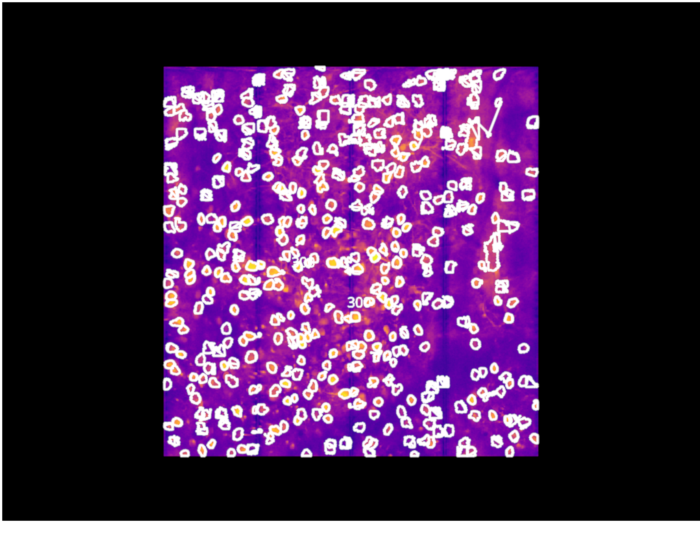

In [149]:
figure = fpl.Figure(size=(700, 560))
image_graphic = figure[0, 0].add_image(data=corr, name="Correlation Image")
subplot = figure[0, 0]
graphic = subplot.add_line_collection(
    filtered,
    name="contours"
)
figure.show()

In [150]:
figure.close()

## (Optional) Adjust parameters and rerun CNMF

In [143]:
from copy import deepcopy
params = deepcopy(params_cnmf)
params['main']['K'] = 5
params

{'main': {'fr': 9.60806,
  'use_cnn': False,
  'dxy': (1.04, 1.0),
  'method_init': 'greedy_roi',
  'K': 5,
  'gSig': (7, 7),
  'gSiz': (15, 15),
  'merge_thr': 0.7,
  'p': 2,
  'tsub': 1,
  'ssub': 1,
  'rf': 30,
  'stride': 12,
  'method_deconvolution': 'oasis',
  'low_rank_background': None,
  'update_background_components': True,
  'del_duplicates': True,
  'min_SNR': 1.5,
  'rval_thr': 0.8}}

In [144]:
cnmf_df.caiman.add_item(
    algo='cnmf',
    input_movie_path=mcorr_df.iloc[0], # our registration results row
    params=params,
    item_name=f'k_5_cnmf',
)

In [145]:
cnmf_df.iloc[-1].caiman.run()

Running b9d43fcf-3aa8-4cf8-b186-c934afd77aa1 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                          k_5_cnmf
input_movie_path    d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...
params              {'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 5, 'gSig': (7, 7), ...
outputs                                                                                                                                None
added_time                                                                                                              2024-12-07T16:24:46
ra

C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    91379242 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    91379242 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    91379242 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    91379242 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

making memmap


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    91393988 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    91393988 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    91393988 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    91393988 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

performing CNMF
fitting images
performing eval


In [153]:
cnmf_df = cnmf_df.caiman.reload_from_disk()
cnmf_df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,cnmf,mcorr_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 50, 'gSig': (7, 7),...",{'mean-projection-path': a5c2f791-6d1b-4712-a66f-2c92adde5d61\a5c2f791-6d1b-4712-a66f-2c92adde5d61_mean_projection.n...,2024-12-07T14:25:59,2024-12-07T16:01:05,363.6 sec,None,a5c2f791-6d1b-4712-a66f-2c92adde5d61
1,cnmf,k_5_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 5, 'gSig': (7, 7), ...",{'mean-projection-path': b9d43fcf-3aa8-4cf8-b186-c934afd77aa1\b9d43fcf-3aa8-4cf8-b186-c934afd77aa1_mean_projection.n...,2024-12-07T16:24:46,2024-12-07T16:26:18,90.23 sec,None,b9d43fcf-3aa8-4cf8-b186-c934afd77aa1


RFBOutputContext()

JupyterWgpuCanvas(css_height='560px', css_width='700px')
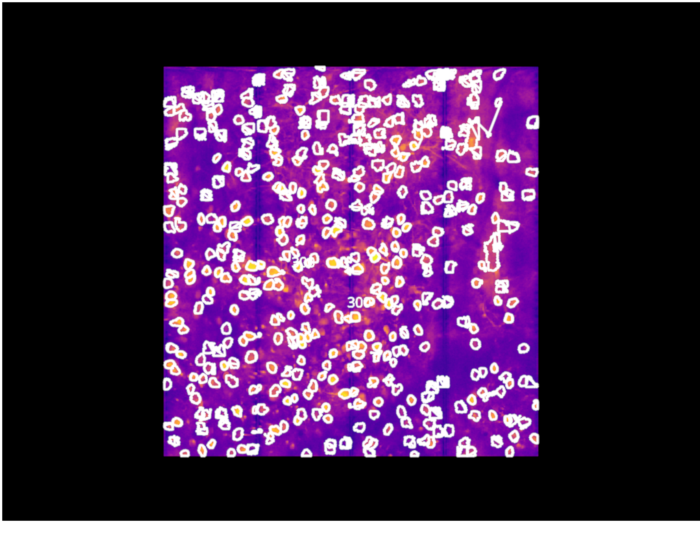

In [151]:
# Same as above
contours = cnmf_df.iloc[-1].cnmf.get_contours("good", swap_dim=False)
filtered = [a for a in contours[0] if a.size > 1]

figure = fpl.Figure(size=(700, 560))
image_graphic = figure[0, 0].add_image(data=corr, name="Correlation Image")
subplot = figure[0, 0]
graphic = subplot.add_line_collection(
    filtered,
    name="contours"
)
figure.show()

In [152]:
figure.close()

## Evaluate CNMF Results

The next step is to adjust evaluation parameters, `min_SNR` and `rval_thr` (and `cnn_thr` if you used `use_cnn=True`).

These parameters **will not compensate for poorly-calculated initialization parameters**.

If you did not properly set `K` (number of neurons per-patch) to your patch size, and you see too many neurons, you should instead rereun segmentation with these parameters tuned to the dataset.

```{note}
Neurons cannot be "added" after initialization (calling `caiman.run()` is initialization). They can be removed quite easily. 

For this reason, you should overestimate K by a few values per patch.
```

In [105]:
from mesmerize_viz import *
viz = cnmf_df.cnmf.viz(start_index=-1)
viz.show()

C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\traitlets\traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Layout).__init__(disabled=True).
object.__init__() takes exactly one argument (the instance to initialize)
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(
c:\users\rbo\repos\mesmerize-viz\mesmerize_viz\_cnmf.py:633: DeprecationWarning: the description_tooltip argument is deprecated, use tooltip instead
  self.checkbox_zoom_components = Checkbox(
c:\users\rbo\repos\mesmerize-viz\mesmerize_viz\_cnmf.py:639: DeprecationWarning: the description_tooltip argument is deprecated, use tooltip instead
  self.zoom_components_scale = FloatSlider(
c:\users\rbo\repos\mesmerize-viz\mesmerize_viz\_cnmf.py:662: DeprecationWarning: the description_tooltip argument is deprecated, use tooltip instead
  self._radio_visible_components = RadioButtons(
c:\users\rbo\repos\mesmerize-viz\mesmerize_viz\_cnmf.py:670: Depr

RFBOutputContext()

RFBOutputContext()

RFBOutputContext()

In [106]:
viz.close()

## Parameter Gridsearch

Once you have a close approximation for a value of `K`, `rf`, `stride` and `gSig`, we can further tune these values with a grid-search.

```{note}
Don't include `min_SNR` or `rval_thr` in your parameter search. These can be more effectively assessed in via `mesmerize-viz`.
```

In [155]:
cnmf_df.iloc[-1].params['main']['K']
cnmf_df.iloc[-1].params['main']['gSig']

(7, 7)

In [160]:
# itertools.product makes it easy to loop through parameter variants
# basically, it's easier to read that deeply nested for loops
from copy import deepcopy
from itertools import product

# variants of several parameters
gSig_variants = [4, 10]
K_variants = [10, 25]

# always use deepcopy like before
new_params_cnmf = deepcopy(params_cnmf)

# create a parameter grid
parameter_grid = product(gSig_variants, K_variants)

# a single for loop to go through all the various parameter combinations
for gSig, K in parameter_grid:
    # deep copy params dict just like before
    new_params_cnmf = deepcopy(new_params_cnmf)

    new_params_cnmf["main"]["gSig"] = [gSig, gSig]
    new_params_cnmf["main"]["K"] = K

    # add param combination variant to batch
    cnmf_df.caiman.add_item(
        algo="cnmf",
        # TODO: This may not be a solution to choosing a name if you want a parameter variant in the name
        item_name=cnmf_df.iloc[-1]["item_name"],
        input_movie_path=cnmf_df.iloc[-1].caiman.get_input_movie_path(),
        params=new_params_cnmf
    )

In [165]:
cnmf_df.caiman.get_params_diffs(algo="cnmf", item_name=cnmf_df.iloc[-1]["item_name"])

,gSig,K
1,"(7, 7)",5
2,"(4, 4)",10
3,"(4, 4)",25
4,"(10, 10)",10
5,"(10, 10)",25


## Run the `cnmf` batch items

In [167]:
for i, row in cnmf_df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        cnmf_df = cnmf_df.caiman.reload_from_disk()

Running a5561c84-a784-433d-9e92-44112397245f with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                          k_5_cnmf
input_movie_path    d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...
params              {'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 10, 'gSig': (4, 4),...
outputs                                                                                                                                None
added_time                                                                                                              2024-12-07T17:11:24
ra

C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    94307817 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94307817 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94307817 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94307817 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

making memmap


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    94323262 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94323262 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94323262 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94323262 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

performing CNMF
fitting images
performing eval
Running 65c34bc6-8f23-480e-a96a-7643afa52653 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                          k_5_cnmf
input_movie_path    d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...
params              {'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 25, 'gSig': (4, 4),...
outputs                                                                                                                                None
added_time                                                                                     

C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    94416773 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94416773 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94416773 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94416773 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

making memmap


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    94431435 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94431435 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94431435 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94431435 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

performing CNMF
fitting images
performing eval
Running b322669d-7a04-4823-9003-97f6c96c9d7f with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                          k_5_cnmf
input_movie_path    d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...
params              {'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 10, 'gSig': (10, 10...
outputs                                                                                                                                None
added_time                                                                                     

C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    94597409 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94597409 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94597409 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94597409 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

making memmap


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    94612117 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94612117 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94612117 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94612117 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

performing CNMF
fitting images
performing eval
Running 8661d079-d63e-470e-a2a9-4bb74ea29dc2 with local backend
************************************************************************

Starting CNMF item:
algo                                                                                                                                   cnmf
item_name                                                                                                                          k_5_cnmf
input_movie_path    d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...
params              {'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 25, 'gSig': (10, 10...
outputs                                                                                                                                None
added_time                                                                                     

C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    94703685 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94703685 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94703685 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94703685 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

making memmap


C:\Users\RBO\miniforge3\envs\lcp\lib\site-packages\caiman\cluster.py:225: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  logger.warn('The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman')
    94718135 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94718135 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94718135 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman
    94718135 [cluster.py:setup_cluster():225] [16948] The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of 

performing CNMF
fitting images
performing eval


In [168]:
cnmf_df = cnmf_df.caiman.reload_from_disk()
cnmf_df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,cnmf,mcorr_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 50, 'gSig': (7, 7),...",{'mean-projection-path': a5c2f791-6d1b-4712-a66f-2c92adde5d61\a5c2f791-6d1b-4712-a66f-2c92adde5d61_mean_projection.n...,2024-12-07T14:25:59,2024-12-07T16:01:05,363.6 sec,None,a5c2f791-6d1b-4712-a66f-2c92adde5d61
1,cnmf,k_5_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 5, 'gSig': (7, 7), ...",{'mean-projection-path': b9d43fcf-3aa8-4cf8-b186-c934afd77aa1\b9d43fcf-3aa8-4cf8-b186-c934afd77aa1_mean_projection.n...,2024-12-07T16:24:46,2024-12-07T16:26:18,90.23 sec,None,b9d43fcf-3aa8-4cf8-b186-c934afd77aa1
2,cnmf,k_5_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 10, 'gSig': (4, 4),...",{'mean-projection-path': a5561c84-a784-433d-9e92-44112397245f\a5561c84-a784-433d-9e92-44112397245f_mean_projection.n...,2024-12-07T17:11:24,2024-12-07T17:15:25,108.93 sec,None,a5561c84-a784-433d-9e92-44112397245f
3,cnmf,k_5_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 25, 'gSig': (4, 4),...",{'mean-projection-path': 65c34bc6-8f23-480e-a96a-7643afa52653\65c34bc6-8f23-480e-a96a-7643afa52653_mean_projection.n...,2024-12-07T17:11:24,2024-12-07T17:18:26,180.61 sec,None,65c34bc6-8f23-480e-a96a-7643afa52653
4,cnmf,k_5_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 10, 'gSig': (10, 10...",{'mean-projection-path': b322669d-7a04-4823-9003-97f6c96c9d7f\b322669d-7a04-4823-9003-97f6c96c9d7f_mean_projection.n...,2024-12-07T17:11:24,2024-12-07T17:20:12,106.26 sec,None,b322669d-7a04-4823-9003-97f6c96c9d7f
5,cnmf,k_5_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 25, 'gSig': (10, 10...",{'mean-projection-path': 8661d079-d63e-470e-a2a9-4bb74ea29dc2\8661d079-d63e-470e-a2a9-4bb74ea29dc2_mean_projection.n...,2024-12-07T17:11:24,2024-12-07T17:23:20,188.52 sec,None,8661d079-d63e-470e-a2a9-4bb74ea29dc2


In [216]:
image_data_options = [ "input", ]
viz = cnmf_df.cnmf.viz(start_index=0, image_data_options=image_data_options)
viz.show()

RFBOutputContext()

RFBOutputContext()

RFBOutputContext()

In [217]:
viz.close()

## Pick the best parameter set

In [221]:
rows_keep = [0]
for i, row in cnmf_df.iterrows():
    if i not in rows_keep:
        cnmf_df.caiman.remove_item(row.uuid, safe_removal=False)
cnmf_df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,cnmf,k_5_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 10, 'gSig': (4, 4),...",{'mean-projection-path': a5561c84-a784-433d-9e92-44112397245f\a5561c84-a784-433d-9e92-44112397245f_mean_projection.n...,2024-12-07T17:11:24,2024-12-07T17:15:25,108.93 sec,None,a5561c84-a784-433d-9e92-44112397245f


## Adjust quality metrics based on evaluation parameters

``` python
min_SNR: float
    trace SNR threshold
SNR_lowest: float
    minimum required trace SNR
rval_thr: float
    space correlation threshold
rval_lowest: float
    minimum required space correlation
use_cnn: bool
    flag for using the CNN classifier
min_cnn_thr: float
    CNN classifier threshold
```

In [218]:
from copy import deepcopy

new_params = deepcopy(cnmf_df.iloc[0].params)

# assign the "max_shifts"
new_params["main"]["min_SNR"] = 2.1
new_params["main"]["SNR_lowest"] = 3.25
new_params["main"]["rval_thr"] = 0.3
# new_params["main"]["rval_lowest"] = 0.0

In [219]:
cnmf_df = cnmf_df.caiman.reload_from_disk()
cnmf_df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,cnmf,k_5_cnmf,d2323217-2056-4681-9656-2ddebc721ac4\d2323217-2056-4681-9656-2ddebc721ac4-plane_10_els__d1_600_d2_576_d3_1_order_F_f...,"{'main': {'fr': 9.60806, 'use_cnn': False, 'dxy': (1.04, 1.0), 'method_init': 'greedy_roi', 'K': 10, 'gSig': (4, 4),...",{'mean-projection-path': a5561c84-a784-433d-9e92-44112397245f\a5561c84-a784-433d-9e92-44112397245f_mean_projection.n...,2024-12-07T17:11:24,2024-12-07T17:15:25,108.93 sec,None,a5561c84-a784-433d-9e92-44112397245f


In [222]:
output_path = Path(cnmf_df.iloc[0].input_movie_path).stem
for i, row in mcorr_df.iterrows():
    # Don't process the same file twice
    if Path(row.mcorr.get_output_path()).stem == output_path:
        continue

    cnmf_df.caiman.add_item(
        algo='cnmf',
        input_movie_path=row,
        params=new_params,          # use the same parameters
        item_name=f'cnmf_batch',  # filename of the movie, but can be anything
    )

In [225]:
# double check that the new value is set properly
cnmf_df.iloc[-1].params['main']['min_SNR']

2.1

In [ ]:
for i, row in cnmf_df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip

    process = row.caiman.run()

    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        cnmf_df = cnmf_df.caiman.reload_from_disk()

## Extras

In [ ]:
import fastplitlib as fpl

# create image widget for raw neural activity
raw_iw = fpl.Figure()

# re-add our identified good components from before using the SNR mapping
contours_graphic = raw_iw[0,0].add_line_collection(data=contours, cmap="spring", thickness=2, name="contours")

# get temporal components
temporal = df.iloc[row_ix].cnmf.get_temporal(component_indices="good")

# temporal plot
plot_temporal = fpl.Figure(size=(600,100))
plot_temporal[0,0].add_line(temporal[0], colors="magenta")

# add a linear selector to temporal trace
plot_temporal[0,0].graphics[0].add_linear_selector()

# show temporal plot and mcorr/rcm plot in ipywidgets VBox
sc = Sidecar()

# with sc:
display(VBox([raw_iw.show(), plot_temporal.show()]))

In [24]:
index = -1  # the last item added

rcb = df.iloc[index].cnmf.get_rcb()
residuals = df.iloc[index].cnmf.get_residuals()
input_movie = df.iloc[index].caiman.get_input_movie()

# temporal components
temporal = df.iloc[index].cnmf.get_temporal()

temporal_good = df.iloc[index].cnmf.get_temporal("good")
temporal_bad = df.iloc[index].cnmf.get_temporal("bad")

temporal_with_residuals = df.iloc[index].cnmf.get_temporal(add_residuals=True)

correlation_image = df.iloc[-1].caiman.get_corr_image()

components_good = df.iloc[-1].cnmf.get_good_components()
components_bad = df.iloc[-1].cnmf.get_bad_components()

mean_img = df.iloc[-1].caiman.get_projection('mean')
std_img = df.iloc[-1].caiman.get_projection('std')

masks = df.iloc[-1].cnmf.get_masks()

print(f'Temporal Components (good/bad): {temporal_good.shape} / {temporal_bad.shape}')
print(f'Spatial Components (good/bad): {components_good.shape} / {components_bad.shape}')

Temporal Components (good/bad): (2111, 1000) / (2683, 1000)
Spatial Components (good/bad): (2111,) / (2683,)


In [ ]:
row_ix = 1
# get the contours and center of masses using mesmerize_core
contours, coms = df.iloc[row_ix].cnmf.get_contours(component_indices="good", swap_dim=False)

# get the signal-to-noise ratio of each "good" component to color components
snr_comps = df.iloc[row_ix].cnmf.get_output().estimates.SNR_comp

# get the good component_ixs
good_ixs = df.iloc[row_ix].cnmf.get_good_components()

# only get snr_comps of good_ixs
snr_comps = snr_comps[good_ixs]

np.log10(snr_comps)[:10]